## Using Pystan to fit Model 3. 
### Accessibility with Household and transportation costs (% of income) with random intercepts and slopes and a spatial lag

We can use PyStan to easily specify multilevel models, and fit them using Hamiltonian Monte Carlo. Stan is useful in very high dimensional problems, where there are a large numbers of predictors to infer. In this instance we have over 16,000 rows of data so therefore using Stan's computationally efficient sampling strategies is appropriate.

In [3]:
%matplotlib inline
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import fiona
import seaborn as sns
#import libpysal
import pysal
#import mapclassify as mc
import shapely
from shapely.geometry import Point, Polygon, LineString
sns.set(style="ticks", palette="muted", color_codes=True)

pd.options.display.max_rows = 10

/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [4]:
Data_clean_all_col = pd.read_csv('Spatial_weights_all.csv', delimiter = ',', encoding='latin-1', converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Data_clean_all_col['GEOID10']=Data_clean_all_col['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Data_clean_all_col.head()

,Unnamed: 0,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fourth_qui,Top_5_perc,perc_below,perc_bel_1,Less_high_,High_schoo,Black_Afri,Hispanic,White_Alon,populati_1
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,98321.0,166923.0,1075.0,8.0,3137.0,670.0,1.138852,37.122208,73.893999,4566


Load in the spatial lag dataset

In [5]:
Lag_pred_for_merge = pd.read_csv('Lag_pred_for_merge.csv', delimiter = ',',converters={'GEOID10': lambda x: str(x), 'BlockId': lambda x: int(x), 'BlockgroupId': lambda x: int(x), 'TractId': lambda x: int(x)}
)
Lag_pred_for_merge['GEOID10']=Lag_pred_for_merge['GEOID10'].apply(lambda x: '{0:0>15}'.format(x))
Lag_pred_for_merge.head()

,Unnamed: 0,GEOID10,populati_1,yb,lag_ht_ami,lag_Lowest_Qui,lag_Hispanic,lag_Black_Afri,lag_White_Alon,lag_Less_high_,...,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_0_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,060371011101000,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,9441.088,89468.05,96512.68,77364.130,80264.734
1,2,060371011101007,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10524.009,89468.05,96512.68,77364.130,80264.734
2,3,060371011101008,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10315.592,89468.05,96512.68,77364.130,80264.734
3,4,060371011101011,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10270.440,89468.05,96512.68,77364.130,80264.734
4,5,060371011102004,4566,1 High,47.0,14394.0,52.738706,2.846268,77.858679,4027.0,...,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,11573.969,93797.41,104498.48,83827.266,88984.016


In [6]:
All_data = Data_clean_all_col.merge(Lag_pred_for_merge,
                                    on='GEOID10')
All_data.head()

,Unnamed: 0_x,X,OBJECTID_1,GEOID10,CTCB10,BG10,X_CENTER,Y_CENTER,COMMNAME,CB10,...,Fit_2_Tot_r_10,Fit_3_Tot_r_10,Fit_4_Tot_r_10,Fit_5_Tot_r_10,Fit_6_Tot_r_10,ANN_0_Tot_r_10,ANN_1_Tot_r_10,ANN_2_Tot_r_10,ANN_3_Tot_r_10,ANN_4_Tot_r_10
0,1,1,48354,060371011101000,1011101000,1011101,6475454.31,1917493.83,Los Angeles - Tujunga,1000,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,9441.088,89468.05,96512.68,77364.130,80264.734
1,2,2,31442,060371011101007,1011101007,1011101,6474224.94,1916298.68,Los Angeles - Tujunga,1007,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10524.009,89468.05,96512.68,77364.130,80264.734
2,3,3,35619,060371011101008,1011101008,1011101,6474718.45,1916291.85,Los Angeles - Tujunga,1008,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10315.592,89468.05,96512.68,77364.130,80264.734
3,4,4,89321,060371011101011,1011101011,1011101,6475268.08,1916284.43,Los Angeles - Tujunga,1011,...,853.474224,5687.844585,-14641.369980,-784.432774,-882.625161,10270.440,89468.05,96512.68,77364.130,80264.734
4,5,5,84366,060371011102004,1011102004,1011102,6472361.62,1916319.86,Los Angeles - Tujunga,2004,...,-3581.635544,-37870.046870,-528.113892,-219.208947,1476.780679,11573.969,93797.41,104498.48,83827.266,88984.016


We also need a lookup table (`list`) for each unique block, block group and tract, for indexing.

In [7]:
unique_blocks = All_data.BlockId.unique().tolist()
unique_bgs = All_data.BlockgroupId.unique().tolist()
unique_tracts = All_data.TractId.unique().tolist()

Then define the length of the lists for blocks, block groups and tracts. 

In [8]:
N = len(unique_blocks)
J = len(unique_bgs)
Q = len(unique_tracts)

In [9]:
print(N,J,Q)

16470 3221 1306


### Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{j} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [10]:
block_to_bg = dict(Data_clean_all_col[['BlockId', 'BlockgroupId']].values)

In [11]:
block_to_bg_vector = [unique_bgs.index(bg) + 1 for bg in block_to_bg.values()]

Then create a dictionary to summarise block group variability at the tract level.

In [12]:
bg_to_tract = dict(Data_clean_all_col[['BlockgroupId', 'TractId']].values)

In [13]:
bg_to_tract_vector = [unique_tracts.index(tract) + 1 for tract in bg_to_tract.values()]

In [14]:
bglevel = All_data.groupby('BlockgroupId')\
                            [['ht_ami']].apply(np.mean).values

In [15]:
bglevel_1 = All_data.groupby('BlockgroupId')\
                            [['lag_ht_ami']].apply(np.mean).values

As there is no greater heirarchical level than the tract, we summarise like this.

In [16]:
tractlevel = np.zeros((Q,1))

In [17]:
varying_intercept_slope = """
data {
  int<lower=0> N; 
  int<lower=0> P_N; 
  int<lower=0> J; 
  int<lower=0> P_J; 
  int<lower=0> Q; 
  int<lower=0> P_Q; 
  int<lower=1, upper=J> block_to_bg[N];
  int<lower=1, upper=Q> bg_to_tract[J];
  vector[J] ht_ami;
  vector[J] ht_ami_lag;
  vector[N] y;
} 
parameters {
  vector[J] bg_intercept;
  vector[Q] tract_intercept;
  real hypermean;
  vector[J] ht_ami_slope;
  vector[J] ht_ami_slope_lag;
  real<lower=0> sigma_block;
  real<lower=0> sigma_bg;
  real<lower=0> sigma_tract;
}
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] = bg_intercept[block_to_bg[i]] 
               + ht_ami[block_to_bg[i]] * ht_ami_slope[block_to_bg[i]]
               + ht_ami_lag[block_to_bg[i]] * ht_ami_slope_lag[block_to_bg[i]];    
}
model {
  for (j in 1:J)
    bg_intercept[j] ~ normal(tract_intercept[bg_to_tract[j]], sigma_bg);
  y ~ normal(y_hat, sigma_block);
}
"""

In [18]:
data_for_model = dict(
    N = N,
    P_N = 1,
    J = J,
    P_J = 1,
    Q = Q,
    P_Q = 1,
    block_to_bg = block_to_bg_vector,
    bg_to_tract = bg_to_tract_vector,
    ht_ami = bglevel.flatten(),
    ht_ami_lag = bglevel_1.flatten(),
    y = All_data['Tot_r_10'].values
)

In [22]:
sm3 = pystan.StanModel(model_code=varying_intercept_slope)
fit3 = sm3.sampling(data=data_for_model, 
                    iter=6000, 
                    chains=4, warmup=500, 
                    thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4ecc1e6c80dd1e454291ad4d5fb63862 NOW.
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/0p/m5mxm89s0wz39hmyq__7qjc00000gn/T/tmpi1nwzvcs/stanfit4anon_model_4ecc1e6c80dd1e454291ad4d5fb63862_4671266340707938479.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/numpy/core/_methods.py:107: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [23]:
summary_dict = fit3.summary()
fit3_df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
fit3_df.to_csv('./ht_ami and lag_ht_ami/Predictions_IQR.csv')

In [2]:
import pickle

In [1]:
with open('./ht_ami and lag_ht_ami/stanmodel_slopes_and_intercepts_model_sm_3.pkl', 'wb') as outfile:
    sm3 = pickle.dump(sm3, outfile)
with open('./ht_ami and lag_ht_ami/stanmodel_slopes_and_intercepts_result_fit_3.pkl', 'wb') as outfile:
    fit3 = pickle.dump(fit3, outfile)

NameError: name 'pickle' is not defined

In [30]:
test_3 = fit_3.to_dataframe()

In [31]:
test_3.head()

,chain,chain_idx,warmup,divergent__,energy__,treedepth__,accept_stat__,stepsize__,n_leapfrog__,bg_intercept[1],...,y_hat[16462],y_hat[16463],y_hat[16464],y_hat[16465],y_hat[16466],y_hat[16467],y_hat[16468],y_hat[16469],y_hat[16470],lp__
0,1,1,0,1,208028.016579,4,0.951831,0.083915,21,13.260531,...,4377.301057,4377.301057,4377.301057,4377.301057,4377.301057,4377.301057,4377.301057,4377.301057,4377.301057,-202493.612042
1,1,2,0,1,207912.065101,2,0.856537,0.083915,7,13.258507,...,4369.322144,4369.322144,4369.322144,4369.322144,4369.322144,4369.322144,4369.322144,4369.322144,4369.322144,-202493.837724
2,1,3,0,1,207873.628233,3,0.928327,0.083915,14,13.260129,...,4341.172264,4341.172264,4341.172264,4341.172264,4341.172264,4341.172264,4341.172264,4341.172264,4341.172264,-202494.015990
3,1,4,0,1,208013.339457,2,0.857072,0.083915,7,13.258762,...,4338.232675,4338.232675,4338.232675,4338.232675,4338.232675,4338.232675,4338.232675,4338.232675,4338.232675,-202494.431698
4,1,5,0,1,207959.469975,2,0.856632,0.083915,7,13.270125,...,4327.070079,4327.070079,4327.070079,4327.070079,4327.070079,4327.070079,4327.070079,4327.070079,4327.070079,-202493.899096


In [ ]:
test_3.to_csv('./stanmodel_slopes_and_intercepts_fit3.csv')

In [ ]:
pred3 = test_3.loc[:,'y_hat[1]':'y_hat[16470]']


In [ ]:
pred3.to_csv('./Pred_fit3.csv')

In [32]:
pred_2000_3 = test_3.loc[21999:21999,'y_hat[1]':'y_hat[16470]']
pred_2000_3

,y_hat[1],y_hat[2],y_hat[3],y_hat[4],y_hat[5],y_hat[6],y_hat[7],y_hat[8],y_hat[9],y_hat[10],...,y_hat[16461],y_hat[16462],y_hat[16463],y_hat[16464],y_hat[16465],y_hat[16466],y_hat[16467],y_hat[16468],y_hat[16469],y_hat[16470]
21999,853.474224,853.474224,853.474224,853.474224,-3581.635544,4654.6328,1419.656945,1419.656945,1419.656945,133.276999,...,6084.562121,6084.562121,6084.562121,6084.562121,6084.562121,6084.562121,6084.562121,6084.562121,6084.562121,6084.562121


In [33]:
pred_trans_3 = pred_2000_3.transpose()

In [34]:
pred_trans_3.to_csv('./Pred_3_1_trans.csv')

#### Plotting Pystan Results for Model 3

In [ ]:
fit3.traceplot('bg_intercept')

In [ ]:
fit3.traceplot('sigma_bg')

In [ ]:
fit3.traceplot('ht_ami_slope')

In [ ]:
xvals = np.arange(2)
b = fit3['bg_intercept'].mean(axis=0)
m = fit3['ht_ami_slope'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.savefig("Multilevel_fit3_ht_ami.png", format="PNG")


In [26]:
fit3['ht_ami'].mean()

ValueError: No parameter ht_ami

The estimate for the `ht_ami` coefficient is approximately 10.4, which can be interpreted as houses with over 10% of their income being spent on household and transportation costs having over more than the average accessibility to employment by private transportation (after 10 mins of travel time) of those with less than 10% of income spent on housing and transportation, after accounting for the block.

In [ ]:
fit3['lag_ht_ami'].mean()

In [26]:
import pickle 
with open('./ht_ami and lag_ht_ami/stanmodel_slopes_and_intercepts_model_sm_3.pkl', 'rb') as infile:
    sm_3 = pickle.load(infile)

In [27]:
import pickle
with open('./ht_ami and lag_ht_ami/stanmodel_slopes_and_intercepts_result_fit_3.pkl', 'rb') as infile:
    fit_3 = pickle.load(infile)

In [21]:
summary_dict = fit_3.summary()
fit3_df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


fit3_df.head()

NameError: name 'fit_3' is not defined

In [20]:
fit3_df.head()

NameError: name 'fit3_df' is not defined

In [54]:
alpha = fit_3['bg_intercept']
beta = fit_3['tract_intercept']

ValueError: too many values to unpack (expected 2)

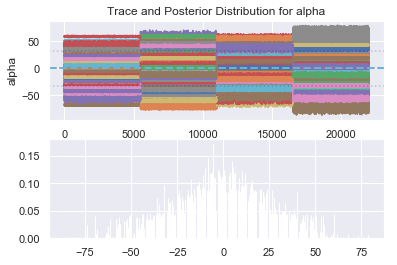

In [55]:
sns.set()

# Nice plot parameters
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
#matplotlib.rc('text', usetex=True)


def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()
    
plot_trace(beta, 'alpha') 
plt.show()
plot_trace(beta, 'beta') 
plt.show()

In [46]:
# Extracting traces

sigma_block = fit_3['sigma_block']
sigma_bg = fit_3['sigma_bg']
sigma_tract = fit_3['sigma_tract']

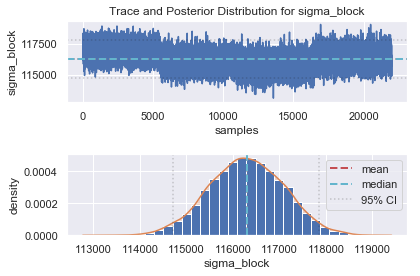

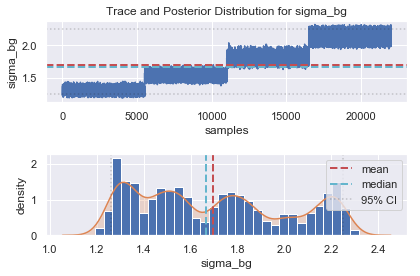

/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/matplotlib/axes/_base.py:2492: RuntimeWarning: overflow encountered in double_scalars
  x1t += delta
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:468: RuntimeWarning: overflow encountered in double_scalars
  b = np.max(X) + cut * bw
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/numpy/core/function_base.py:159: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: overflow encountered in subtract
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/admin/anaconda3/envs/pystan_2/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)


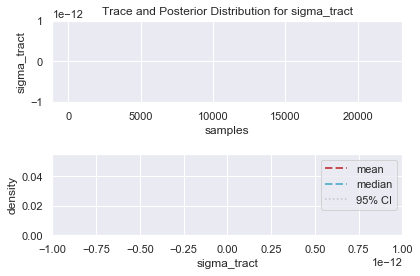

In [51]:
sns.set()

# Nice plot parameters
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
#matplotlib.rc('text', usetex=True)


def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
    
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
    
    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    
    plt.gcf().tight_layout()
    plt.legend()


plot_trace(sigma_block, 'sigma_block') 
plt.show()
plot_trace(sigma_bg, 'sigma_bg') 
plt.show()
plot_trace(sigma_tract, 'sigma_tract') 
plt.show()

In [19]:
sigma_b_chain, sigma_bg_chain, sigma_t_chain, sigma_ht_ami_chain, sigma_ht_ami_lag_chain = fit_3.extract(['sigma_block', 'sigma_bg', 'sigma_tract', 'ht_ami_slope', 'ht_ami_slope_lag']).values()

In [25]:
sigma_b = sigma_b_chain.mean()
sigma_bg = sigma_bg_chain.mean()
sigma_t = sigma_t_chain.mean()
sigma_ht_ami = sigma_ht_ami_chain.mean()
sigma_lag_ht_ami = sigma_ht_ami_lag_chain.mean()
sigma_lag_ht_ami

3.070907185304786

In [82]:
sigma_b_chain, sigma_bg_chain, sigma_t_chain = fit_3.extract(['sigma_block', 'sigma_bg', 'sigma_tract']).values()

In [83]:
sigma_b = sigma_b_chain[-500:].mean()
sigma_bg = sigma_bg_chain[-500:].mean()
sigma_t = sigma_t_chain[-500:].mean()

In [84]:
block_to_bg_dummies = pd.get_dummies(block_to_bg_vector).values
bg_to_tract_dummies = pd.get_dummies(bg_to_tract_vector).values

In [85]:
block_to_bg_dummies.shape

(16470, 3221)

In [86]:
from scipy import sparse

In [87]:
block_to_bg_sparse = sparse.csc_matrix(block_to_bg_dummies)
bg_to_tract_sparse = sparse.csc_matrix(bg_to_tract_dummies)

In [88]:
full_cov = sparse.identity(len(block_to_bg_vector)) * sigma_b**2 \
           + block_to_bg_sparse @ block_to_bg_sparse.T * sigma_bg**2\
           + (block_to_bg_sparse @ (bg_to_tract_sparse @ bg_to_tract_sparse.T) 
              @ block_to_bg_sparse.T) * sigma_t**2

In [89]:
diag = full_cov.diagonal()

In [90]:
under_diag = diag**-.5

In [91]:
n = len(block_to_bg_vector)

In [92]:
full_correlation = sparse.identity(n).multiply(under_diag)\
                   @ (full_cov)\
                   @ sparse.identity(n).multiply(under_diag)

In [93]:
np.unique(full_correlation.data).round(10)

array([nan, nan, nan, ..., nan, nan, nan])

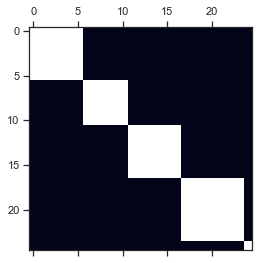

In [94]:
plt.matshow(full_correlation.todense()[:25,:25])
plt.savefig('covariance_fit_2_1_bg.png')

# Removing block level variance

In [95]:
partial_cov = block_to_bg_sparse @ block_to_bg_sparse.T * sigma_bg**2\
           + (block_to_bg_sparse @ (bg_to_tract_sparse @ bg_to_tract_sparse.T) 
              @ block_to_bg_sparse.T) * sigma_t**2
           #+ sparse.identity(len(block_to_bg_vector)) * sigma_b \

In [96]:
partial_diag = partial_cov.diagonal() ** -.5

In [97]:
partial_correlation = sparse.identity(n).multiply(partial_diag)\
                       @ (partial_cov)\
                       @ sparse.identity(n).multiply(partial_diag)

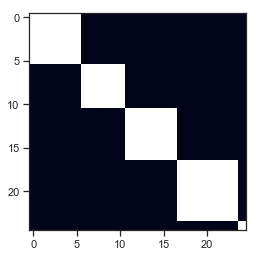

In [98]:
plt.imshow(partial_correlation.todense()[:25,:25])
plt.savefig('covariance_fit_2_1_no_bg.png')

In [104]:
print(sigma_b**2, sigma_bg**2, sigma_t**2)

13560070962.991163 4.641254690447641 inf


# Catterpillar plot

In [99]:
test = fit_3.to_dataframe('ht_ami_slope')

In [100]:
bg_stats = test.median().filter(like='ht_').to_frame('median')
bg_stats['top'] = test.quantile(.975).filter(like='ht_')
bg_stats['bottom'] = test.quantile(.025).filter(like='ht_')

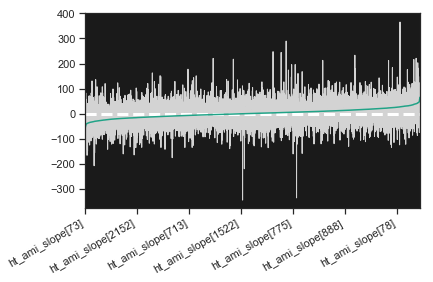

In [102]:
bg_stats.sort_values('median')\
        ['median'].plot(color='#20A387', zorder=2)
plt.fill_between(np.arange(len(bg_stats)), 
                 bg_stats.sort_values('median')['top'],
                 bg_stats.sort_values('median')['bottom'],
                 color='lightgrey', zorder=-1)
plt.hlines(0,*plt.gca().get_xlim(), color='w', linestyle='--', linewidth=3)
plt.gcf().autofmt_xdate()
plt.gca().set_facecolor('k')
#plt.gca().set_xlim(0,100)
#plt.gca().set_ylim(-100,1000)
plt.savefig("fit_3_catterpillar_ht_ami_slope.png", format="PNG")

In [103]:
test_lag = fit_3.to_dataframe('ht_ami_slope_lag')

In [105]:
bg_stats = test_lag.median().filter(like='ht_').to_frame('median')
bg_stats['top'] = test_lag.quantile(.975).filter(like='ht_')
bg_stats['bottom'] = test_lag.quantile(.025).filter(like='ht_')

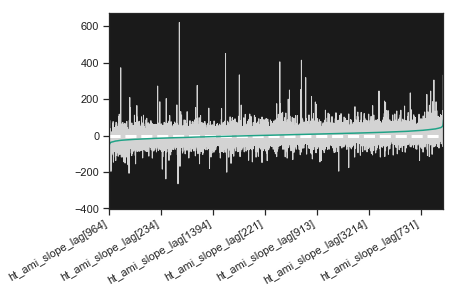

In [106]:
bg_stats.sort_values('median')\
        ['median'].plot(color='#20A387', zorder=2)
plt.fill_between(np.arange(len(bg_stats)), 
                 bg_stats.sort_values('median')['top'],
                 bg_stats.sort_values('median')['bottom'],
                 color='lightgrey', zorder=-1)
plt.hlines(0,*plt.gca().get_xlim(), color='w', linestyle='--', linewidth=3)
plt.gcf().autofmt_xdate()
plt.gca().set_facecolor('k')
#plt.gca().set_xlim(0,100)
#plt.gca().set_ylim(-100,1000)
plt.savefig("fit_3_catterpillar_ht_ami_slope_lag.png", format="PNG")

In [54]:
prediction = pd.read_csv('./Pred_3_1_trans.csv')
prediction.head()

,Unnamed: 0,21999
0,y_hat[1],853.474224
1,y_hat[2],853.474224
2,y_hat[3],853.474224
3,y_hat[4],853.474224
4,y_hat[5],-3581.635544


In [64]:
y_pred = prediction['21999']
y_true = All_data['Tot_r_10']

In [65]:
def r2(pred, obs):
    ess = (pred - obs).T @ (pred - obs)
    tss = obs.var() * obs.shape[0]
    return 1-ess/tss

In [66]:
r2(y_pred, y_true)

-3.123326816635961

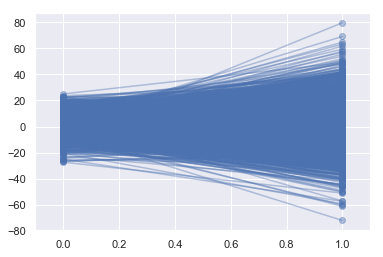

In [28]:
sns.set()
xvals = np.arange(2)
b = fit_3['bg_intercept'].mean(axis=0)
m = fit_3['ht_ami_slope'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.savefig("Multilevel_fit2_1.png", format="PNG")


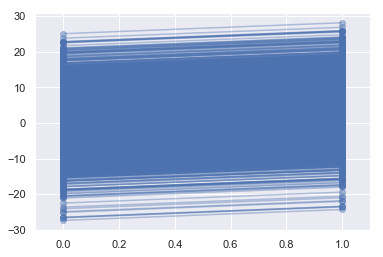

In [31]:
sns.set()
xvals = np.arange(2)
bp = fit_3['bg_intercept'].mean(axis=0)
mp = fit_3['ht_ami_slope_lag'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);
plt.savefig("Multilevel_fit3_lag.png", format="PNG")
